## Zobrazení poslední hodiny teplota_log.csv

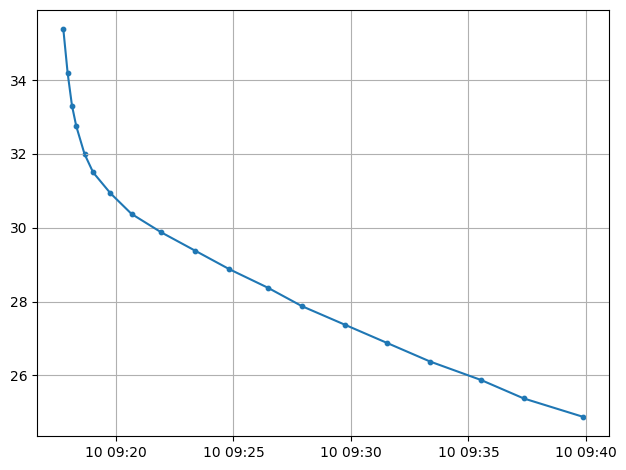

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=1)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [2]:
 
df_plot.tail(20)


,Time,Value
487,2026-02-10 09:17:46,35.375
488,2026-02-10 09:17:57,34.187
489,2026-02-10 09:18:08,33.312
490,2026-02-10 09:18:19,32.750
491,2026-02-10 09:18:40,32.000
492,2026-02-10 09:19:02,31.500
493,2026-02-10 09:19:46,30.937
494,2026-02-10 09:20:40,30.375
495,2026-02-10 09:21:56,29.875
496,2026-02-10 09:23:23,29.375


## Vytvoření df_netatmo ze souboru netatmo_data.csv

In [3]:
import pandas as pd

# Cesta k souboru
path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení dat - tentokrát bez skiprows, protože data začínají hned
df_netatmo = pd.read_csv(path)

# 1) převod z UNIX sekund na datetime
df_netatmo["timestamp"] = ( 
    pd.to_datetime(df_netatmo["timestamp"], unit="s", utc=True) 
    .dt.tz_convert("Europe/Prague") 
)

# 2) pokud chceš formátovaný textový sloupec
df_netatmo["timestamp_str"] = df_netatmo["timestamp"].dt.strftime("%d.%m.%Y %H:%M:%S")


# Ukázka dat
df_netatmo.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,timestamp_str
419,2026-02-10 08:50:10+01:00,21.9,2.7,22,True,1004.9,10.02.2026 08:50:10
420,2026-02-10 08:55:06+01:00,22.0,2.7,22,True,1005.0,10.02.2026 08:55:06
421,2026-02-10 09:00:14+01:00,22.0,2.7,22,True,1004.9,10.02.2026 09:00:14
422,2026-02-10 09:05:09+01:00,22.1,2.8,22,True,1004.9,10.02.2026 09:05:09
423,2026-02-10 09:10:08+01:00,22.1,2.8,22,True,1004.9,10.02.2026 09:10:08
424,2026-02-10 09:15:07+01:00,22.1,2.8,22,True,1004.9,10.02.2026 09:15:07
425,2026-02-10 09:25:07+01:00,22.2,2.9,22,False,1004.9,10.02.2026 09:25:07
426,2026-02-10 09:30:09+01:00,22.2,2.9,22,False,1004.9,10.02.2026 09:30:09
427,2026-02-10 09:35:07+01:00,22.2,2.9,22,False,1004.9,10.02.2026 09:35:07
428,2026-02-10 09:40:12+01:00,22.2,3.0,22,False,1004.9,10.02.2026 09:40:12


## Zobrazení ekvitermních křivek

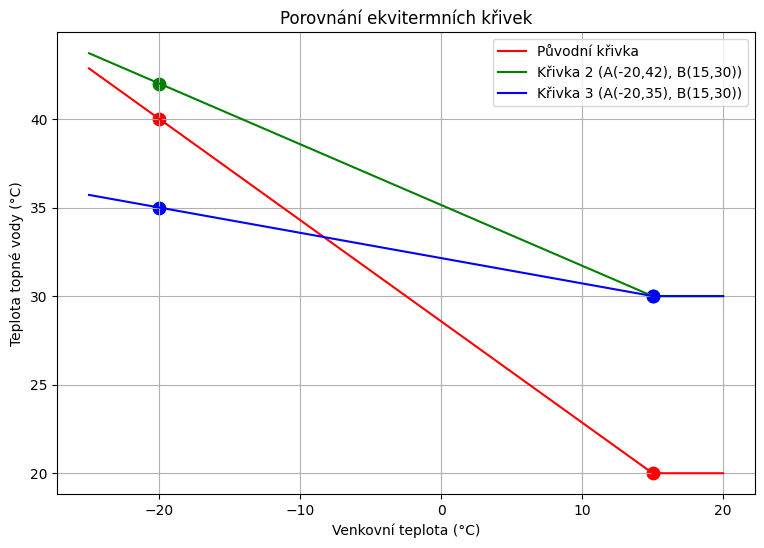

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# 2) Druhá křivka (A(-20,42), B(15,30) – tvoje stará verze)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# 3) Nová křivka podle bodů A(-20,35) a B(15,30)
def hokejka3(temp_in):
    if temp_in <= 15:
        return -0.142857 * temp_in + 32.14286
    else:
        return 30

# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out_1 = [hokejka(t) for t in temps_in]
temps_out_2 = [hokejka2(t) for t in temps_in]
temps_out_3 = [hokejka3(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(9, 6))
plt.plot(temps_in, temps_out_1, label="Původní křivka", color="red")
plt.plot(temps_in, temps_out_2, label="Křivka 2 (A(-20,42), B(15,30))", color="green")
plt.plot(temps_in, temps_out_3, label="Křivka 3 (A(-20,35), B(15,30))", color="blue")

# Body původní křivky
plt.scatter([-20, 15], [40, 20], color="red", s=80)

# Body křivky 2
plt.scatter([-20, 15], [42, 30], color="green", s=80)

# Body křivky 3
plt.scatter([-20, 15], [35, 30], color="blue", s=80)

plt.title("Porovnání ekvitermních křivek")
plt.xlabel("Venkovní teplota (°C)")
plt.ylabel("Teplota topné vody (°C)")
plt.grid(True)
plt.legend()

plt.show()


### Výpočet boiler_water_2 z temp_outdoor v df_netatmo, který byl vytvořen výše

In [4]:
import pandas as pd

# Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# Nová křivka podle bodů A(-20/40) a B(15/30)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# Sloupec Boiler_water
# df_netatmo["Boiler_water"] = df_netatmo["temp_outdoor"].apply(hokejka)

# Nový sloupec Boiler_water_2
df_netatmo["Boiler_water_2"] = df_netatmo["temp_outdoor"].apply(hokejka2)

# Ukázka posledních 10 řádků
df_netatmo.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,timestamp_str,Boiler_water_2
419,2026-02-10 08:50:10+01:00,21.9,2.7,22,True,1004.9,10.02.2026 08:50:10,34.217286
420,2026-02-10 08:55:06+01:00,22.0,2.7,22,True,1005.0,10.02.2026 08:55:06,34.217286
421,2026-02-10 09:00:14+01:00,22.0,2.7,22,True,1004.9,10.02.2026 09:00:14,34.217286
422,2026-02-10 09:05:09+01:00,22.1,2.8,22,True,1004.9,10.02.2026 09:05:09,34.183000
423,2026-02-10 09:10:08+01:00,22.1,2.8,22,True,1004.9,10.02.2026 09:10:08,34.183000
424,2026-02-10 09:15:07+01:00,22.1,2.8,22,True,1004.9,10.02.2026 09:15:07,34.183000
425,2026-02-10 09:25:07+01:00,22.2,2.9,22,False,1004.9,10.02.2026 09:25:07,34.148715
426,2026-02-10 09:30:09+01:00,22.2,2.9,22,False,1004.9,10.02.2026 09:30:09,34.148715
427,2026-02-10 09:35:07+01:00,22.2,2.9,22,False,1004.9,10.02.2026 09:35:07,34.148715
428,2026-02-10 09:40:12+01:00,22.2,3.0,22,False,1004.9,10.02.2026 09:40:12,34.114429


## Graf z df_netatmo

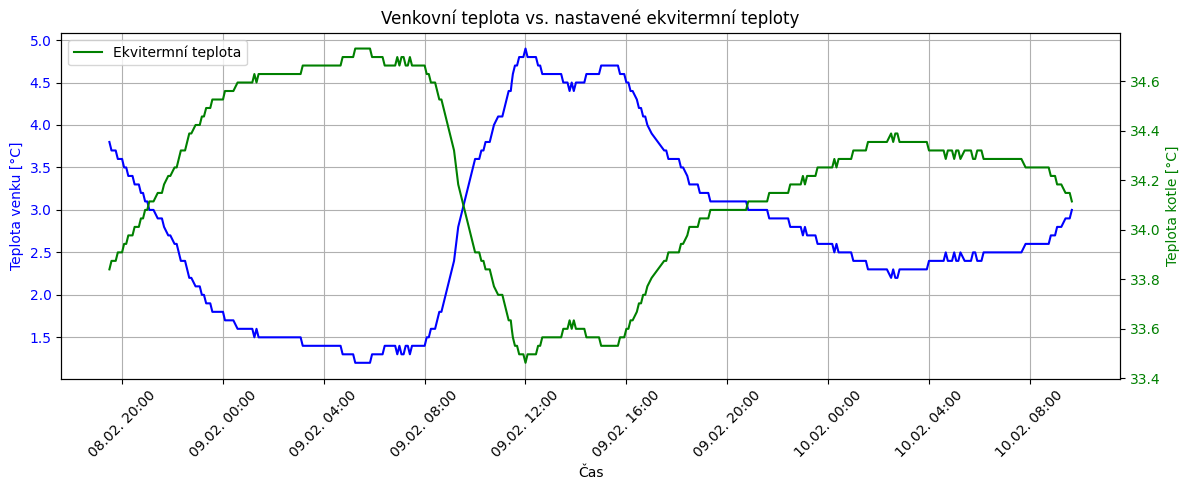

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Posun času o 1 hodinu
df_netatmo["timestamp_shifted"] = df_netatmo["timestamp"] + pd.to_timedelta(1, "h")

fig, ax = plt.subplots(figsize=(12, 5))

# Hlavní osa – venkovní teplota
ax.plot(df_netatmo["timestamp_shifted"], df_netatmo["temp_outdoor"],
        color="blue", label="Teplota venku")
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa – teplota kotle
ax2 = ax.twinx()
ax2.plot(df_netatmo["timestamp_shifted"], df_netatmo["Boiler_water_2"],
         color="green", label="Ekvitermní teplota")
ax2.set_ylabel("Teplota kotle [°C]", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Titulek a popisky
ax.set_title("Venkovní teplota vs. nastavené ekvitermní teploty")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
ax.tick_params(axis='x', rotation=45)

# Legenda
ax2.legend(loc="upper left")

ax.grid(True)
fig.tight_layout()
plt.show()




## Starý soubor teplota_log_old1

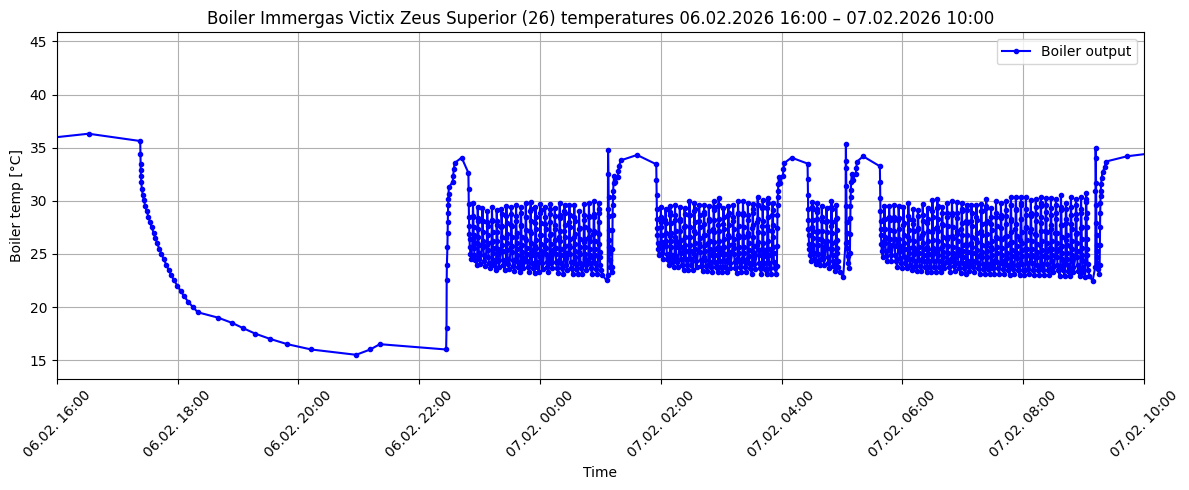

In [68]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


df_old = pd.read_csv("teplota_log_old1.csv", header=None, names=["Time", "Value"])
df_old["Time"] = pd.to_datetime(df_old["Time"], errors="coerce")
df_old["Value"] = pd.to_numeric(df_old["Value"], errors="coerce")
df_old = df_old.dropna().sort_values("Time").drop_duplicates("Time")

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-02-06 16:00:00")
end_time   = pd.Timestamp("2026-02-07 10:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df_old["Time"], df_old["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo – původní křivka
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# Netatmo – nová křivka (Boiler_water_2)
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Nový soubor raspberry teplota_log.csv

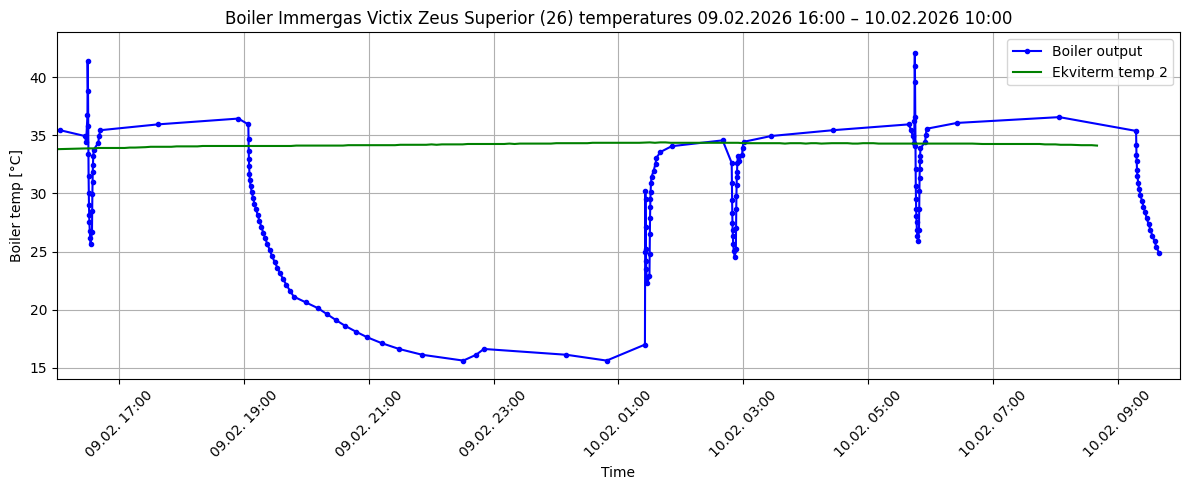

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-02-09 16:00:00")
end_time   = pd.Timestamp("2026-02-10 10:00:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df["Time"], df["Value"], marker=".", color="blue", label="Boiler output")

# Netatmo – původní křivka
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")
# Netatmo – nová křivka (Boiler_water_2)
ax.plot(df_netatmo["timestamp"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")


# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Teplota v prádelně

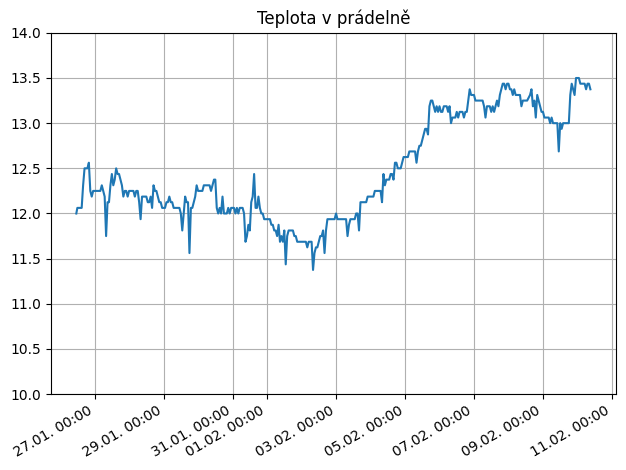

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import mplcursors

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
# df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(10, 14)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"], linestyle="-", marker=None)
# ax.plot(df_pradelna["cas"], df_pradelna["tepl"], marker=".")
# ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=5)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
# mplcursors.cursor(hover=True)
plt.show()




## Import souboru Climate.csv

In [9]:
import pandas as pd

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení CSV bez skiprows – tvůj soubor má jen 1 řádek hlavičky
df_climate = pd.read_csv(path)

# Převod timestamp → datetime
df_climate["time_utc"] = ( 
    pd.to_datetime(df_climate["timestamp"], unit="s", utc=True) 
    .dt.tz_convert("Europe/Prague") 
)

# Volitelně: vytvořit čitelný časový řetězec
df_climate["time_local"] = df_climate["time_utc"].dt.strftime("%d.%m.%Y %H:%M:%S")

# Ukázka filtrace
df_climate.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,time_utc,time_local
419,1770709810,21.9,2.7,22,True,1004.9,2026-02-10 08:50:10+01:00,10.02.2026 08:50:10
420,1770710106,22.0,2.7,22,True,1005.0,2026-02-10 08:55:06+01:00,10.02.2026 08:55:06
421,1770710414,22.0,2.7,22,True,1004.9,2026-02-10 09:00:14+01:00,10.02.2026 09:00:14
422,1770710709,22.1,2.8,22,True,1004.9,2026-02-10 09:05:09+01:00,10.02.2026 09:05:09
423,1770711008,22.1,2.8,22,True,1004.9,2026-02-10 09:10:08+01:00,10.02.2026 09:10:08
424,1770711307,22.1,2.8,22,True,1004.9,2026-02-10 09:15:07+01:00,10.02.2026 09:15:07
425,1770711907,22.2,2.9,22,False,1004.9,2026-02-10 09:25:07+01:00,10.02.2026 09:25:07
426,1770712209,22.2,2.9,22,False,1004.9,2026-02-10 09:30:09+01:00,10.02.2026 09:30:09
427,1770712507,22.2,2.9,22,False,1004.9,2026-02-10 09:35:07+01:00,10.02.2026 09:35:07
428,1770712812,22.2,3.0,22,False,1004.9,2026-02-10 09:40:12+01:00,10.02.2026 09:40:12


## Setpoint a teplota kotle

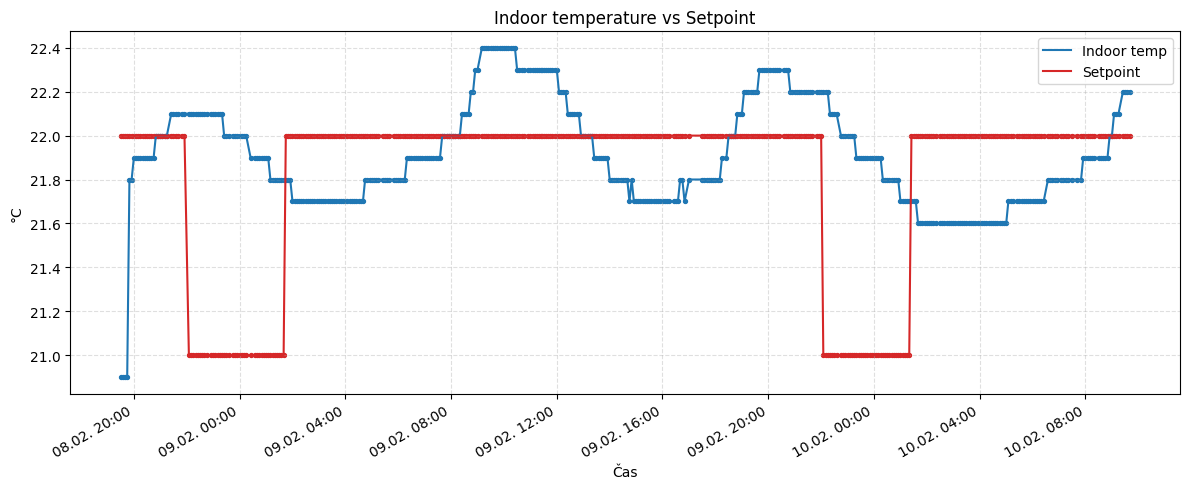

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení CSV
df = pd.read_csv(path)

# Převod timestamp → datetime + posun o 1 hodinu
df["time"] = pd.to_datetime(df["timestamp"], unit="s") + pd.to_timedelta(1, "h")

# -----------------------------
# GRAF
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df["time"], df["temp_indoor"], label="Indoor temp",
        color="tab:blue", linewidth=1.5)
ax.scatter(df["time"], df["temp_indoor"], s=8, color="tab:blue")

ax.plot(df["time"], df["setpoint"], label="Setpoint",
        color="tab:red", linewidth=1.5)
ax.scatter(df["time"], df["setpoint"], s=8, color="tab:red")

ax.set_title("Indoor temperature vs Setpoint")
ax.set_xlabel("Čas")
ax.set_ylabel("°C")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


## Graf z Climate.csv Tlak

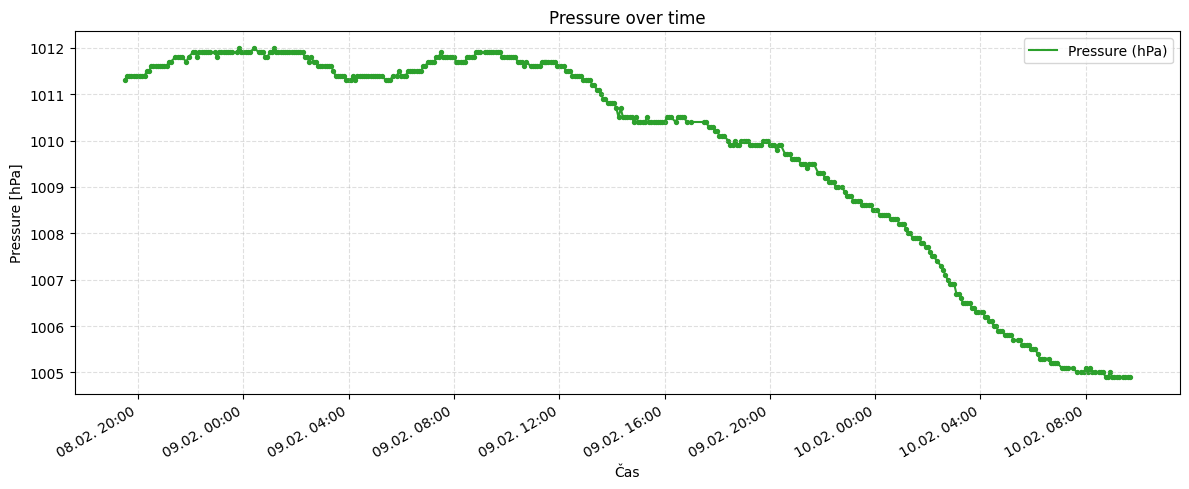

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení CSV
df = pd.read_csv(path)

# Převod timestamp → datetime + posun o 1 hodinu
df["time"] = pd.to_datetime(df["timestamp"], unit="s") + pd.to_timedelta(1, "h")

# -----------------------------
# GRAF TLAKU
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df["time"], df["pressure"],
        label="Pressure (hPa)", color="tab:green", linewidth=1.5)

ax.scatter(df["time"], df["pressure"], s=8, color="tab:green")

ax.set_title("Pressure over time")
ax.set_xlabel("Čas")
ax.set_ylabel("Pressure [hPa]")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

